To run my code,you can upload the file called oracle-fs.zip that can be accessed in https://drive.google.com/file/d/1EbK0zuNpUFYmfZVAq4nDmVWsy7REO4hx/view?usp=sharing%5C. All the code is written by Zhouyu Lu. lol

0. Open our file 

In [ ]:
!unzip oracle_fs.zip

1. Importing required libraries:

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import urllib.parse
import shutil

2. Define dataset

In [ ]:
dataset_path = "Oracle-50K"
train_dir = "train"
test_dir = "test"

# Define train and test dataset
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

3. Preprocessing

In [ ]:

def convert_to_grayscale(image):
    return image.convert("L")

def encode_label(label):
    # Encode label using UTF-8 encoding
    encoded_label = urllib.parse.quote(label, safe='')
    return encoded_label

def split_dataset(dataset_path, train_dir, test_dir, split_ratio=0.75):
    # Clear train and test directories
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)

    # Acquire labels
    labels = os.listdir(dataset_path)

    for label in labels:
        label_dir = os.path.join(dataset_path, label)
        if not os.path.isdir(label_dir):
            continue

        # Aquire all pic
        image_files = os.listdir(label_dir)

        # Sort pic
        image_files.sort()

        # Transfer into binary (black and white) and split the dataset
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(label_dir, image_file)
            image = Image.open(image_path)

            # Convert image to grayscale
            gray_image = convert_to_grayscale(image)

            # Encode label
            encoded_label = encode_label(label)

            # Split the dataset
            if i == 0 and len(image_files) == 1:
                # Single sample as test
                save_dir = os.path.join(test_dir, encoded_label)
            elif i < len(image_files) * split_ratio:
                # Train
                save_dir = os.path.join(train_dir, encoded_label)
            else:
                # Test
                save_dir = os.path.join(test_dir, encoded_label)

            os.makedirs(save_dir, exist_ok=True)

            # Save the image
            save_path = os.path.join(save_dir, image_file)
            gray_image.save(save_path)

    print("Dataset splitting and preprocessing completed.")

# Set the paths for dataset, train directory, and test directory
dataset_path = 'Oracle-50K'
train_dir = 'train'
test_dir = 'test'

# Call the split_dataset function
split_dataset(dataset_path, train_dir, test_dir, split_ratio=0.75)



Dataset splitting and preprocessing completed.


Test if all the labels are well transformed

In [ ]:
import os

train_dir = 'train'

labels = os.listdir(train_dir)

for label in labels:
    label_dir = os.path.join(train_dir, label)
    if not os.path.isdir(label_dir):
        continue
    
    image_files = os.listdir(label_dir)
    print(f"Label: {label}, Number of Images: {len(image_files)}")


Label: %E5%8F%A5, Number of Images: 4
Label: %E5%BC%84, Number of Images: 15
Label: %E7%94%95, Number of Images: 2
Label: %E5%85%AB, Number of Images: 21
Label: %E6%AA%8D, Number of Images: 14
Label: %E5%B0%84, Number of Images: 109
Label: %E9%A5%A3, Number of Images: 21
Label: %E3%AD%89, Number of Images: 7
Label: %E5%A4%8C, Number of Images: 2
Label: %E6%BE%A3, Number of Images: 9
Label: %E6%9B%96, Number of Images: 5
Label: %E4%BB%9F, Number of Images: 6
Label: %E5%AF%83, Number of Images: 2
Label: %E5%85%AE, Number of Images: 27
Label: %E7%88%B6, Number of Images: 76
Label: %E7%88%AA, Number of Images: 6
Label: %E5%AF%90, Number of Images: 4
Label: %E6%98%9C, Number of Images: 22
Label: %E6%A7%9E, Number of Images: 2
Label: %E5%B0%A8, Number of Images: 5
Label: %E7%B5%95, Number of Images: 9
Label: %E6%9A%B9, Number of Images: 12
Label: %E6%94%9C, Number of Images: 6
Label: %E5%8D%89, Number of Images: 15
Label: %E5%AA%9F, Number of Images: 12
Label: %E6%99%BA, Number of Images: 2


4. Here's the model


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)  # Input channel: 1 (grayscale image), Output channel: 64, Kernel size: 5x5
        self.conv2 = nn.Conv2d(64, 128, 5)  # Input channel: 32, Output channel: 64, Kernel size: 5x5
        self.pool = nn.AdaptiveAvgPool2d((10, 10))  # Adaptive Average Pooling to adjust input shape
        self.fc1 = nn.Linear(128 * 10 * 10, 256)  # Fully connected layer, Input size: 64x10x10, Output size: 128
        self.fc2 = nn.Linear(256, 200)  # Fully connected layer, Input size: 128, Output size: 200 (number of classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Max pooling with kernel size 2x2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Max pooling with kernel size 2x2
        x = self.pool(x)  # Adaptive Average Pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel()



5. Define the Loss function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

6. Load our processed data

In [15]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms, Grayscale
from torch.utils.data import DataLoader
from torchvision import datasets



# Define data transformations
transform = transforms.Compose([
    #transforms.Resize(16),
    Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Define paths to train and test directories
train_path = 'oracle_fs/img/oracle_200_5_shot/test'
test_path = 'oracle_fs/img/oracle_200_5_shot/train'

# Create train_dataset
train_dataset = ImageFolder(train_path, transform=transform)

# Create test_dataset
test_dataset = ImageFolder(test_path, transform=transform)

# Define batch size for training and testing
batch_size = 64

# Create train_loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create test_loader
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim


# 定义 Prototypical Networks 模型
class PrototypicalNetworks(nn.Module):
    def __init__(self, num_classes):
        super(PrototypicalNetworks, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(64*11*11, num_classes)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 创建 Prototypical Networks 模型实例
model = PrototypicalNetworks(num_classes=200)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)




In [3]:
import torch

# 检查是否连接到TPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)




cpu


7. Training and Testing

Epoch 1 Loss: 5.276290409148685
Epoch 2 Loss: 4.9646302253480945
Epoch 3 Loss: 3.716554229221647
Epoch 4 Loss: 2.399494893967159
Epoch 5 Loss: 1.732206176197718
Epoch 6 Loss: 1.2979708645078871
Epoch 7 Loss: 0.9636671476893954
Epoch 8 Loss: 0.7096234772886548
Epoch 9 Loss: 0.5377197076403906
Epoch 10 Loss: 0.39314259588718414
Epoch 11 Loss: 0.2953374097271571
Epoch 12 Loss: 0.2682727092788333
Epoch 13 Loss: 0.19489773759056653
Epoch 14 Loss: 0.19711504918005732
Epoch 15 Loss: 0.19696939766170488
Epoch 16 Loss: 0.17894942360737967
Epoch 17 Loss: 0.15352451003023557
Epoch 18 Loss: 0.17008385792492875
Epoch 19 Loss: 0.15254228458636337
Epoch 20 Loss: 0.15143977909807174
Epoch 21 Loss: 0.13941393399404156
Epoch 22 Loss: 0.13040850468216433
Epoch 23 Loss: 0.15156236805376552
Epoch 24 Loss: 0.12371911347976752
Epoch 25 Loss: 0.1205299153096146
Epoch 26 Loss: 0.1296873436501575
Epoch 27 Loss: 0.12707407723757483
Epoch 28 Loss: 0.1393113091055836
Epoch 29 Loss: 0.1180889681572952
Epoch 30 Loss

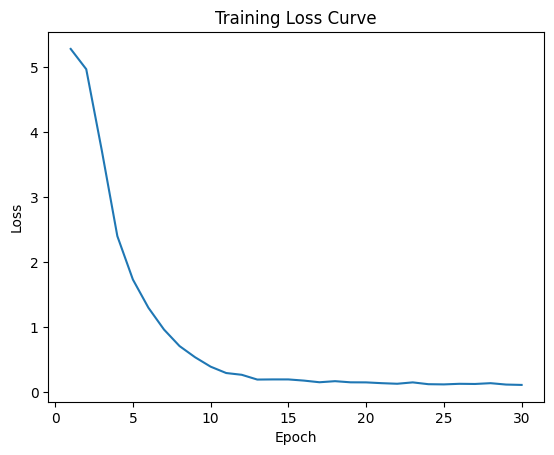

准确率: 63.8%


In [23]:
import matplotlib.pyplot as plt

num_epochs = 30  # 训练轮数
train_losses = []

for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # 计算每个epoch的平均损失
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # 打印每个epoch的损失
    print(f"Epoch {epoch+1} Loss: {epoch_loss}")

print("训练完成！")
# 绘制Loss曲线
plt.plot(range(1, num_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# 测试模型
model.eval()  # 设置模型为评估模式
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"准确率: {accuracy}%") 

Another attempt of Prototypical Networks

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:

from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, data_path, shot, query, img_channels, img_size):
        super(ImageDataset, self).__init__()
        self.shot = shot
        self.query = query
        self.img_channels = img_channels
        self.img_size = img_size

        df = read_data(data_path)
        self.label_imgPaths_dict = df.groupby('label').apply(lambda x: x['filename'].tolist()).to_dict()
        self.labels = list(self.label_imgPaths_dict.keys())

    def __getitem__(self, item):
        label = self.labels[item]

        if label not in DATA_CACHE:
            img_paths = self.label_imgPaths_dict[label]
            data = torch.stack([path_to_img(path, self.img_channels, self.img_size) for path in img_paths], dim=0)
            DATA_CACHE[label] = data  # shape: (num of one class samples, c, w, h)
        else:
            data = DATA_CACHE[label]

        support_data = data[:self.shot]
        query_data = data[-self.query:]
        return support_data, query_data, label  # 返回支持集数据、查询集数据和标签

    def __len__(self):
        return len(self.labels)


In [ ]:
# 定义数据集的路径
support_set_path = "/content/oracle_fs/img/oracle_200_5_shot/train"
query_set_path = "/content/oracle_fs/img/oracle_200_5_shot/test"

# 定义数据预处理和转换
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # 调整图像大小为 50x50
    transforms.ToTensor()  # 将图像转换为张量
])

# 创建支持集和查询集的数据集实例
support_set_dataset = datasets.ImageFolder(support_set_path, transform=transform)
query_set_dataset = datasets.ImageFolder(query_set_path, transform=transform)
num_queries_per_class = len(query_set_dataset) // len(query_set_dataset.classes)



# 定义批处理大小和数据加载器
batch_size = 5  # 每批的样本数量
support_set_loader = DataLoader(support_set_dataset, batch_size=batch_size, shuffle=True)
query_set_loader = DataLoader(query_set_dataset, batch_size=20, shuffle=False)
print(len(support_set_loader))
print(len(query_set_loader))




200
200


In [ ]:
def check_label_range(dataset, num_classes):
    for _, label in dataset:
        if label < 0 or label >= num_classes:
            print(f"Invalid label: {label}. Label should be between 0 and {num_classes-1}.")

# 在加载数据集之后调用check_label_range函数
check_label_range(train_dataset, num_classes)
check_label_range(test_dataset, num_classes)


In [ ]:
# 定义Prototypical Networks的模型结构
class PrototypicalNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(PrototypicalNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

# 定义损失函数
class PrototypicalLoss(nn.Module):
    def __init__(self):
        super(PrototypicalLoss, self).__init__()

    def forward(self, support_set, query_set, labels, num_classes, num_support, num_queries):
        support_set = support_set.reshape(num_classes, num_support, -1)
        query_set = query_set.reshape(num_classes * num_queries, -1)
        labels = labels.repeat_interleave(num_queries)

        prototypes = torch.mean(support_set, dim=1)
        distances = torch.cdist(query_set, prototypes)

        negative_log_prob = nn.functional.log_softmax(-distances, dim=-1)
        loss = nn.functional.nll_loss(negative_log_prob, labels)
        return loss

# 创建模型
input_dim = 64  # 输入维度
hidden_dim = 128  # 隐藏层维度
model = PrototypicalNet(input_dim, hidden_dim)

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 定义损失函数
loss_fn = PrototypicalLoss()

In [ ]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder

# 设置随机种子
torch.manual_seed(42)

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

# 加载数据集
support_dataset = ImageFolder('/content/oracle_fs/img/oracle_200_5_shot/train', transform=transform)
query_dataset = ImageFolder('/content/oracle_fs/img/oracle_200_5_shot/test', transform=transform)

# 定义超参数
num_classes = len(support_dataset.classes)
num_support = 5
num_queries = 20
input_dim = 50 * 50
hidden_dim = 64

# 定义模型
class PrototypicalNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(PrototypicalNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.prototype_layer = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.prototype_layer(x)
        return x

# 创建数据加载器
support_dataloader = DataLoader(support_dataset, batch_size=num_classes, shuffle=True)
query_dataloader = DataLoader(query_dataset, batch_size=num_classes, shuffle=True)

# 创建模型
model = PrototypicalNetwork(input_dim, hidden_dim, num_classes)

# 定义损失函数
loss_fn = nn.CrossEntropyLoss()

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)






ValueError: ignored

In [ ]:

# 训练过程
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for support_images, support_labels in support_dataloader:
        optimizer.zero_grad()
        support_images = support_images.reshape(-1, input_dim)
        support_labels = support_labels.repeat(num_queries)

        num_classes_batch = support_images.size(0)
        num_samples = support_images.size(1)
        num_support_batch = num_samples // num_classes_batch

        support_encoded = model(support_images)

        query_images, query_labels = next(iter(query_dataloader))
        query_images = query_images.reshape(-1, input_dim)
        query_labels = query_labels.reshape(-1)

        query_encoded = model(query_images)

        loss = loss_fn(query_encoded, query_labels)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, batch_idx+1, len(support_dataloader), loss.item()))

# 在测试集上进行测试
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for support_images, support_labels in support_dataloader:
        support_images = support_images.reshape(-1, input_dim)
        support_labels = support_labels.repeat(num_queries)

        num_classes_batch = support_images.size(0)
        num_samples = support_images.size(1)
        num_support_batch = num_samples // num_classes_batch

        support_encoded = model(support_images)

        query_images, query_labels = next(iter(query_dataloader))
        query_images = query_images.reshape(-1, input_dim)
        query_labels = query_labels.reshape(-1)

        query_encoded = model(query_images)

        distances = torch.cdist(query_encoded, support_encoded)
        predicted_labels = torch.argmin(distances, dim=1)

        total_correct += (predicted_labels == query_labels).sum().item()
        total_samples += len(query_labels)

    accuracy = total_correct / total_samples
    print('Test Accuracy: {:.2f}%'.format(accuracy * 100))


ValueError: ignored